# Preciction of the AMOC with VIKING20X

This notebook performs the same experiment as `06_argo_prediction` but with the simulation data.

Hypothesis: If this works with simulation data the fault is the noise in the argo data. 



In [1]:
"""

What do I need for the calculation?

- dv_dz_obs from the simulation
- ds_argo_merged_10days from simulated argos
- t_umo_10days as a ground truth

"""

import xarray as xr

time_smoothing = '10D'

#### dv_dz

In [7]:
# dv_dz_obs
dv_dz_sim = xr.open_dataset('../rapid-geostrophic-reconstruction/data/dv_dz_sim_miss.nc')
dv_dz_sim = dv_dz_sim.resample(time = time_smoothing).mean()

# dv_dz_sim is the same position and depth per time as the original moorings data
dv_dz_sim

<xarray.Dataset>
Dimensions:        (z: 242, time: 653)
Coordinates:
  * z              (z) float64 -4.82e+03 -4.8e+03 -4.78e+03 ... -40.0 -20.0 -0.0
  * time           (time) datetime64[ns] 2004-04-02 2004-04-12 ... 2022-02-07
Data variables:
    dv_dz_times_X  (time, z) float64 -4.097 -4.098 -4.098 -4.098 ... nan nan nan

#### ds_argo_merged_10days

In [4]:
from pathlib import Path
from xarray import open_mfdataset, open_dataset
def find_grid_files(grid_type, years, nest, model, delta_t, folder = 'output'): 
    experiment_path = Path('/gxfs_work/geomar/smomw355/model_data/ocean-only/')
    nest_part = '1_' if nest else '' 

    if len(grid_type) < 2:
        grid_type = f'grid_{grid_type}'

    grid_files = (experiment_path / model / 'nemo' / folder).glob(f'{nest_part}{model}_{delta_t}_*_*_{grid_type}.nc')
    grid_files = list(grid_files)
    
    result_files = []
    for file in grid_files:
        start_year = int(str(file).split('/')[-1].split('_')[- (3 + grid_type.count('_'))][:4])
        
        if (years[0] is None or start_year >= years[0]) and \
           (years[1] is None or start_year < years[1]):
            result_files.append(file)
    
    return sorted(result_files)

def load_dataset_from_grid_type(grid_type, years, nest, model, delta_t, chunks = {"time_counter" : 2,"y": 2, "x": None}, **kwargs):
    files_list = find_grid_files(grid_type, years, nest, model, delta_t, **kwargs)
    grid = open_mfdataset(
        files_list, # type: ignore
        chunks= chunks,
        combine='by_coords'
    )
    return grid

def load_masks(nest, model):

    if str.startswith(model, 'VIKING20X.L46-KFS003'):
        # All the mask for the long runs VIKING20X.L46-KFS003-2nd, ... are placed in the original experiment
        model = 'VIKING20X.L46-KFS003' 
    
    nest_part = '1_' if nest else ''
    
    mask_mesh = open_dataset(
        f'/gxfs_work/geomar/smomw355/model_data/ocean-only/{model}/nemo/suppl/{nest_part}mesh_mask.nc',
        decode_cf=False,
        chunks={'y': 512, 'x':512},
    )
    mask_glo = open_dataset(
        f'/gxfs_work/geomar/smomw355/model_data/ocean-only/{model}/nemo/suppl/{nest_part}new_maskglo.nc',
        decode_cf=False,
        chunks={'Y':512, 'X':512}
    )

    mask_mesh = mask_mesh.squeeze()
    mask_glo = mask_glo.rename({'X':'x', 'Y':'y'}).squeeze() # Rename coordinates to have the same name as the data file
    
    return mask_mesh, mask_glo

In [5]:
# ds_argo_merged_10days
import numpy as np
from sklearn.metrics.pairwise import haversine_distances    


obs_argo_array = xr.open_dataset('../rapid-geostrophic-reconstruction/data/ds_argo_10D.nc')

mask_mesh, _ = load_masks(True, 'VIKING20X.L46-KFS003')

c_mask_mesh = mask_mesh.assign_coords({'x': np.arange(mask_mesh.x.shape[0]), 'y': np.arange(mask_mesh.y.shape[0])})

lon_min = obs_argo_array.lon.min() - 2
lon_max = obs_argo_array.lon.max() + 2
lat_min = obs_argo_array.lat.min() - 2
lat_max = obs_argo_array.lat.max() + 2

year_min = obs_argo_array.time.dt.year.min()
year_max = obs_argo_array.time.dt.year.max() + 1



In [10]:


cutted_c_mask = c_mask_mesh.where(
    ((lat_min <= mask_mesh.nav_lat) & (mask_mesh.nav_lat <= lat_max) & (lon_min <= mask_mesh.nav_lon) & (mask_mesh.nav_lon <= lon_max)).compute()
    , drop = True)

lonlat_model = np.vstack((cutted_c_mask.where(cutted_c_mask.tmaskutil > 0).nav_lon.stack({'list': ['x', 'y']}).values, cutted_c_mask.where(cutted_c_mask.tmaskutil > 0).nav_lat.stack({'list': ['x', 'y']}).values)).T


lonlat_argo = np.vstack((obs_argo_array.stack(f=('time', 'pos')).lon.values, obs_argo_array.stack(f=('time', 'pos')).lat.values)).T.astype(float)
print(lonlat_model.shape, lonlat_argo.shape)
print(lonlat_model)
print(lonlat_argo)

non_nan_model_mask = np.all(~np.isnan(lonlat_model), axis = -1)
non_nan_argo_mask = np.all(~np.isnan(lonlat_argo), axis = -1)

argo_indices_without_nans = []
for chunk in np.array_split(lonlat_argo[non_nan_argo_mask], 5):
    argo_indices_without_nans_chunk = np.nanargmin(haversine_distances(np.radians(lonlat_model[non_nan_model_mask]), np.radians(chunk)), axis= 0)
    argo_indices_without_nans.append(argo_indices_without_nans_chunk)

argo_indices_without_nans = np.concatenate(argo_indices_without_nans, axis = 0)

non_nan_model_indices = np.argwhere(non_nan_model_mask).squeeze()
argo_indices = non_nan_model_indices[argo_indices_without_nans]


XY_indices = np.array([*cutted_c_mask.where(cutted_c_mask.tmaskutil > 0).stack({'list': ['x', 'y']}).list.isel(list = xr.DataArray(argo_indices)).values])


KeyboardInterrupt: 

In [6]:
import numpy as np
XY_indices = np.load('../rapid-geostrophic-reconstruction/data/07_XY_indices.npy')

In [7]:
first_nan_index = np.isnan(obs_argo_array.temperature).argmax('z') 

depth = obs_argo_array.z.isel(z = (first_nan_index - 1)).where(first_nan_index > 0)
obs_argo_array = obs_argo_array.assign_coords({'depth': depth})

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [8]:
import pandas as pd
df = obs_argo_array.isel(z = 0).to_dataframe()
argo_frame = df[~pd.isna(df['profile_mask'])]

argo_frame = argo_frame.assign(model_x = XY_indices[:, 0], model_y =  XY_indices[:, 1])
argo_frame = argo_frame.reset_index()
argo_frame.time_1d = argo_frame.time_1d + np.timedelta64(12, 'h')

#filter the argo frame such that in column time only datetimes between the year year_min and 2019 are present
# argo_frame = argo_frame[(argo_frame.time.dt.year >= year_min) & (argo_frame.time.dt.year < 2020)]

T = load_dataset_from_grid_type('T', (year_min, year_max), True, 'VIKING20X.L46-KFS003', '1d', chunks={'time_counter': 1, 'x': 100, 'y' :100})


# all_argos = all_argos.assign(model_x = ('N_PROF', XY_indices[:, 0]), model_y = ('N_PROF', XY_indices[:, 1]))
# nT = T.time_counter.shape[0]
# argo_counts = np.random.normal(argo_count_mean, argo_count_std, size = (nT,)).astype(int)

# argos_per_ts = argo_counts.max()        


# random_assigned_floats = argo_frame.iloc[np.random.randint(0, argo_frame.shape[0], size = (int(nT * argos_per_ts),))]
# random_assigned_floats = random_assigned_floats.assign(time_model = np.tile(T.time_counter, (argos_per_ts, 1)).T.flatten())

modified_T = T.sel(
    y = xr.DataArray(argo_frame.model_y.values),
    x = xr.DataArray(argo_frame.model_x.values),
    # deptht = slice(None, T_with_stress.deptht[DEPTH_DIM - 1]),
    time_counter = xr.DataArray(argo_frame.time_1d.values),
)


/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]


In [9]:

modified_T = modified_T.assign(
    votemper_depth_max = modified_T.votemper.where(-modified_T.deptht >= xr.DataArray(argo_frame.depth.values), 0.0),
    vosaline_depth_max = modified_T.vosaline.where(-modified_T.deptht >= xr.DataArray(argo_frame.depth.values), 0.0),
    depth_max = argo_frame.depth.astype(np.float32)
)



In [43]:
max_argos_per_ts = modified_T.time_counter.groupby('time_counter').count().max().values[()]

profile_index = np.arange(max_argos_per_ts)
time_index = T.time_counter.values


pandas_multiindex = pd.MultiIndex.from_product([time_index, profile_index], names = ['time_counter', 'profiles'])


In [10]:
modified_T = modified_T.assign_coords(time_counter_1d = modified_T.time_counter)
modified_T = modified_T.assign_coords(time_counter_smooth = modified_T.time_counter.dt.round(time_smoothing))
modified_T

<xarray.Dataset>
Dimensions:               (deptht: 46, dim_0: 28867, axis_nbounds: 2)
Coordinates:
  * deptht                (deptht) float32 3.047 9.454 ... 5.625e+03 5.875e+03
    nav_lat               (dim_0) float32 dask.array<chunksize=(28867,), meta=np.ndarray>
    nav_lon               (dim_0) float32 dask.array<chunksize=(28867,), meta=np.ndarray>
    time_centered         (dim_0) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    time_counter          (dim_0) datetime64[ns] 2001-06-06T12:00:00 ... 2023...
  * dim_0                 (dim_0) int64 0 1 2 3 4 ... 28863 28864 28865 28866
    time_counter_1d       (dim_0) datetime64[ns] 2001-06-06T12:00:00 ... 2023...
    time_counter_smooth   (dim_0) datetime64[ns] 2001-06-07 ... 2023-08-11
Dimensions without coordinates: axis_nbounds
Data variables: (12/21)
    deptht_bounds         (dim_0, deptht, axis_nbounds) float32 dask.array<chunksize=(23, 46, 2), meta=np.ndarray>
    sobowlin              (dim_0) float32 dask.array<chunksize=(28867,), meta=np.ndarray>
    sohefldo              (dim_0) float32 dask.array<chunksize=(28867,), meta=np.ndarray>
    sohefldp              (dim_0) float32 dask.array<chunksize=(28867,), meta=np.ndarray>
    somixhgt              (dim_0) float32 dask.array<chunksize=(28867,), meta=np.ndarray>
    somxl010              (dim_0) float32 dask.array<chunksize=(28867,), meta=np.ndarray>
    ...                    ...
    time_counter_bounds   (dim_0, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    vosaline              (dim_0, deptht) float32 dask.array<chunksize=(28867, 46), meta=np.ndarray>
    votemper              (dim_0, deptht) float32 dask.array<chunksize=(28867, 46), meta=np.ndarray>
    votemper_depth_max    (dim_0, deptht) float32 dask.array<chunksize=(28867, 46), meta=np.ndarray>
    vosaline_depth_max    (dim_0, deptht) float32 dask.array<chunksize=(28867, 46), meta=np.ndarray>
    depth_max             (dim_0) float32 -1.54e+03 -1.54e+03 ... -1.98e+03
Attributes:
    name:         /p/scratch/viking/schwarzkopf1/VIKING20X.L46/VIKING20X.L46-...
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2021-Jan-11 02:36:55 GMT
    uuid:         e98955d8-a2fa-4956-9962-c086464b4650
    history:      Wed Jan 13 17:59:23 2021: ncrcat tmp_2001/1_VIKING20X.L46-K...
    NCO:          netCDF Operators version 4.9.6 (Homepage = http://nco.sf.ne...

In [11]:
time_counter_array = modified_T.time_counter_smooth.values
pos = []

indices = {}

for i in range(0, time_counter_array.shape[0]):

    ts = time_counter_array[i] 


    if ts in indices:
        pos.append(indices[ts])
        indices[ts] += 1
    else:
        indices[ts] = 1
        pos.append(0)

pos = np.array(pos)

modified_T = modified_T.assign_coords({'profiles': ('dim_0', pos)})

In [12]:
pandas_multiindex = pd.MultiIndex.from_tuples([(a,b) for a,b in zip(modified_T.time_counter_smooth.values, modified_T.profiles.values)], names = ['time_counter', 'profiles'])

In [13]:
dataset = modified_T.assign(dim_0 = pandas_multiindex).unstack('dim_0')

In [2]:
from dask.distributed import Client
client = Client(n_workers=16, threads_per_worker=1, memory_limit='5GB')
# print the dashboard link
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 74.51 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35591,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 74.51 GiB
Comm: tcp://127.0.0.1:40225,Total threads: 1
Dashboard: http://127.0.0.1:45459/status,Memory: 4.66 GiB
Nanny: tcp://127.0.0.1:33281,


In [2]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import os

cluster = SLURMCluster(
    cores=1,
    # processes=1,
    memory="10GB",
    shebang='#!/usr/bin/env bash',
    queue="base",
    walltime="03:00:00",
    local_directory='/tmp',
    death_timeout="15s",
    interface="ib0",
    log_directory=f'/gxfs_work/geomar/smomw507/geomar/rapid-geostrophic-reconstruction/logs',
    )

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.18.4.131:8787/status,
Dashboard: http://172.18.4.131:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.18.4.131:38947,Workers: 0
Dashboard: http://172.18.4.131:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
cluster.scale(200)

In [14]:
dataset.votemper_depth_max.load()
print('--> Loaded temp')
dataset.vosaline_depth_max.load()
print('--> Loaded salt')


/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 12.72 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/distributed/worker.py:2995: UserWarning: Large object of size 1.66 MiB detected in task graph: 
  ([[0], [1], [2], [3], [4], [5], [6], [7], [8], [9] ... ', 25648, 0)"])
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


--> Loaded temp
--> Loaded salt


In [15]:
dataset.votemper_depth_max.sel(time_counter = '2014-08-08').isel(profiles = 63)

<xarray.DataArray 'votemper_depth_max' (deptht: 46)>
array([28.264463 , 28.238647 , 28.208616 , 27.806242 , 26.724878 ,
       25.55764  , 24.549019 , 23.753445 , 23.105373 , 22.510283 ,
       21.954395 , 21.486542 , 21.109934 , 20.842573 , 20.486639 ,
       20.115086 , 19.794985 , 19.39209  , 18.671638 , 16.352127 ,
       12.816653 ,  9.034573 ,  6.3333173,  5.113237 ,  4.6365666,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ], dtype=float32)
Coordinates:
    time_counter         datetime64[ns] 2014-08-08
    profiles             int64 63
  * deptht               (deptht) float32 3.047 9.454 ... 5.625e+03 5.875e+03
    nav_lat              float32 30.0
    nav_lon              float32 -70.66
    time_centered        datetime64[ns] 2014-08-11T12:00:00
    time_counter_1d      datetime64[ns] 2014-08-11T12:00:00
    time_counter_smooth  datetime64[ns] 2014-08-08
Attributes:
    standard_name:       sea_water_potential_temperature
    long_name:           temperature
    units:               degC
    online_operation:    average
    interval_operation:  300 s
    interval_write:      1 d
    cell_methods:        time: mean (interval: 300 s) time_counter: mean

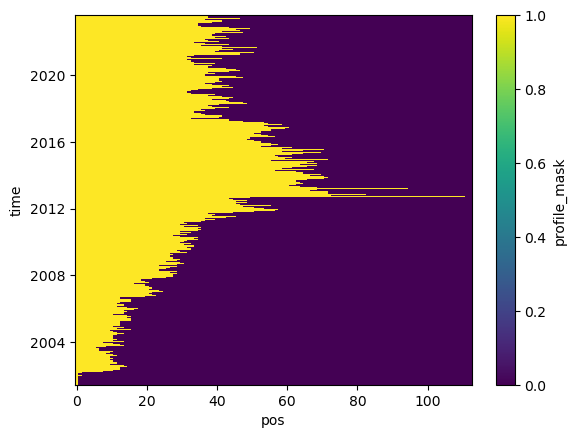

In [16]:

viking_argo_ds = xr.Dataset(
    {
        'temperature': (('z', 'time', 'pos'), dataset.votemper_depth_max.values),
        'salinity': (('z', 'time', 'pos'), dataset.vosaline_depth_max.values),
        'profile_mask': (('time', 'pos'), ~np.isnan(dataset.votemper_depth_max.isel(deptht = 0)).values),
    },
    coords = {
        'time': dataset.time_counter.values,
        'pos': dataset.profiles.values,
        'z': -dataset.deptht.values,
        'pressure': ('z',dataset.deptht.values),
        'lon': (('time', 'pos'), dataset.nav_lon.values),
        'lat': (('time', 'pos'), dataset.nav_lat.values),
        'time_1d': (('time','pos'), dataset.time_counter_1d.values),
    }
)
viking_argo_ds.profile_mask.plot()

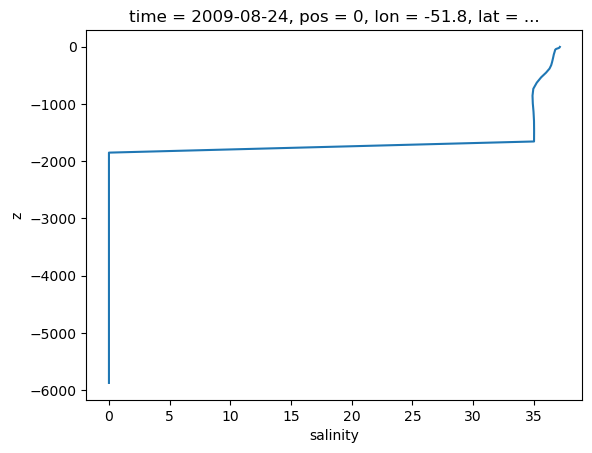

In [23]:
from gsw import CT_from_pt, rho

viking_argo_ds['ct']  = CT_from_pt(viking_argo_ds.salinity, viking_argo_ds.temperature)
viking_argo_ds['rho'] = rho(viking_argo_ds.salinity, viking_argo_ds.temperature, viking_argo_ds.pressure)

viking_argo_ds = viking_argo_ds.transpose('time', 'pos', 'z')
viking_argo_ds = viking_argo_ds.sortby('z')
viking_argo_ds.isel(time = 300, pos = 0).salinity.plot(y = 'z')

In [26]:
viking_argo_ds

<xarray.Dataset>
Dimensions:       (time: 811, pos: 113, z: 46)
Coordinates:
  * time          (time) datetime64[ns] 2001-06-07 2001-06-17 ... 2023-08-11
  * pos           (pos) int64 0 1 2 3 4 5 6 7 ... 106 107 108 109 110 111 112
  * z             (z) float32 -5.875e+03 -5.625e+03 -5.375e+03 ... -9.454 -3.047
    pressure      (z) float32 5.875e+03 5.625e+03 5.375e+03 ... 9.454 3.047
    lon           (time, pos) float32 -70.3 nan nan nan nan ... nan nan nan nan
    lat           (time, pos) float32 28.33 nan nan nan nan ... nan nan nan nan
    time_1d       (time, pos) datetime64[ns] 2001-06-06T12:00:00 NaT ... NaT NaT
Data variables:
    temperature   (time, pos, z) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    salinity      (time, pos, z) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    profile_mask  (time, pos) bool True False False False ... False False False
    ct            (time, pos, z) float64 0.01528 0.01528 0.01528 ... nan nan nan
    rho           (time, pos, z) float64 1.028e+03 1.027e+03 ... nan nan

In [27]:
viking_argo_ds.to_netcdf(f'../rapid-geostrophic-reconstruction/data/ds_argo_{time_smoothing}_viking.nc')

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/xarray/coding/times.py:618: RuntimeWarning: invalid value encountered in cast
  int_num = np.asarray(num, dtype=np.int64)


#### t_umo_10days as a ground truth

In [ ]:
# t_umo_10days
t_umo_sim = xr.open_dataset(f'../rapid-geostrophic-reconstruction/data/t_umo_sim_miss.nc')
t_umo_sim = t_umo_sim.resample(time = time_smoothing).mean()
t_umo_sim

<xarray.Dataset>
Dimensions:        (time: 653)
Coordinates:
    z              float64 -1e+03
  * time           (time) datetime64[ns] 2004-04-02 2004-04-12 ... 2022-02-07
Data variables:
    dv_dz_times_X  (time) float64 -20.04 -21.19 -21.0 ... -15.73 -15.8 -15.74